In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Database Reading and Manipulation
import pandas as pd

# Linear Algebra
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Processing results
import json

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

# Modeling
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Processing
from sklearn.preprocessing import StandardScaler

# Data imputation
from sklearn.impute import SimpleImputer

# Pipeline
from sklearn.pipeline import Pipeline

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score


# Custom modules
## Model selection
from src.cross_validation.blocking_time_series_split import BlockingTimeSeriesSplit

## Function to print scores
from src.utils.print_scores import print_scores

## Function to calculate score regression metrics
from src.utils.score_regression_metrics import score_regression_metrics

## Function to fill the results metric dict
from src.utils.fill_results_dict import fill_results_dict

<IPython.core.display.Javascript object>

In [3]:
SEED = 47
METRICS = (
    "neg_root_mean_squared_error",
    "neg_mean_absolute_error",
    "neg_mean_absolute_percentage_error",
    "r2",
)
METRICS_DICT = {
    "neg_root_mean_squared_error": "RMSE",
    "neg_mean_absolute_error": "MAE",
    "neg_mean_absolute_percentage_error": "MAPE",
    "r2": "R2",
}

<IPython.core.display.Javascript object>

In [4]:
def get_linreg_df_importances(scores):
    coefs = {}
    bias = {}
    coefs_with_column = []
    columns = x.columns

    for index, pipeline in enumerate(scores["estimator"]):
        model = pipeline.named_steps["estimator"]
        coefs[index] = model.coef_.copy()
        bias[index] = model.intercept_.copy()

    for index, coefs_vec in coefs.items():
        coefs_col = pd.DataFrame(
            {col: [c] for col, c in zip(columns, coefs_vec)},
            index=[f"Coefficients - {index}"],
        )
        coefs_with_column.append(coefs_col)
    df_bias = pd.Series(bias)
    df_coefs = pd.concat(coefs_with_column)

    return df_coefs, df_bias

<IPython.core.display.Javascript object>

In [5]:
def get_xgboost_importances(scores, importance_type="gain"):
    tree_importances = []

    for index, pipeline in enumerate(scores["estimator"]):
        model = pipeline.named_steps["estimator"]
        importances_dict = (
            model.get_booster().get_score(importance_type=importance_type).copy()
        )
        tree_importances.append(
            pd.DataFrame(
                importances_dict.values(),
                index=importances_dict.keys(),
                columns=[f"Value - {index}"],
            ).T
        )

    df_importances = pd.concat(tree_importances)

    return df_importances

<IPython.core.display.Javascript object>

In [6]:
def get_random_forest_df_importances(scores):
    importances = {}
    importances_with_column = []
    columns = x.columns

    for index, pipeline in enumerate(scores["estimator"]):
        model = pipeline.named_steps["estimator"]
        importances[index] = model.feature_importances_

    for index, importances_vec in importances.items():
        importances_col = pd.DataFrame(
            {col: [c] for col, c in zip(columns, importances_vec)},
            index=[f"Importances - {index}"],
        )
        importances_with_column.append(importances_col)
    df_importances = pd.concat(importances_with_column)

    return df_importances

<IPython.core.display.Javascript object>

## Defining a dataframe structure to save the results

In [7]:
results_to_save = []

results_dict = {
    "Category": "Local Model",
    "Company": "partner_ii",
    "Features": "Chemical + Mineralogical",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "Linear Regression",
    "Model Params": None,
    "Scaler": "Standard Scaler",
    "Scaler Params": None,
    "Imputer": "Median",
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

# Reading the dataset

In [8]:
df = pd.read_csv("../../../../data/processed/partner_ii/cement-shipping.csv")

<IPython.core.display.Javascript object>

In [10]:
df.columns

Index(['Date', 'Cement_Type', 'CaO', 'SiO2', 'Al2O3', 'Fe2O3', 'MgO', 'SO3',
       'K2O', 'Na2O', 'Total C3S', 'Total C2S', 'C3A', 'C4AF', 'Free CaO',
       'Loss on Ignition', 'Initial setting time', 'CS1', 'CS3', 'CS7', 'CS28',
       'Blaine', 'Sieve 32 um', 'Sieve 45 um'],
      dtype='object')

<IPython.core.display.Javascript object>

# Chemical + Mineralogical Features

## Defining Features

In this set of experiments we keep only chemical and mineralogical features yielded by the same testing method/procedure

In [12]:
df_copy = df.drop(
    [
        # Properties
        #"loi",
        #"water_demand",
        "Initial setting time",
        "Blaine",
        "Sieve 32 um",
        "Sieve 45 um",
        "CS1",
        "CS3",
        "CS7",
        
        # Removing One-Hot encoding variables
        #"unified_material_name_Type III",
        #"unified_material_name_Type IL"
        
        "Cement_Type"
    ],
    axis=1,
).copy()


<IPython.core.display.Javascript object>

# 1. Linear Regression

<h2>1. Dataset: df_no_cs</h2> <br>In this dataset the CS1, CS3  and CS7 variables are not considered. Only Chemical and mineralogical features measured by the same method. For this particular dataset, all chemical features, with the exception of LOI were measured by XRF and XRD methods.

In [13]:
y = df_copy.pop("CS28").values
x = df_copy.drop(["Date"], axis=1)
dates = df["Date"].copy()

<IPython.core.display.Javascript object>

## Repeated KFold Cross validation

In [14]:
repeats = 3
n_splits = 5
pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("transformer", StandardScaler()),
        ("estimator", LinearRegression()),
    ]
)
cv = RepeatedKFold(n_splits=n_splits, n_repeats=repeats, random_state=SEED)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    return_estimator=True,
)
print("Repeated Cross Validation:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Repeated KFold"
results_dict_copy["Cross Validation Params"] = '{"N_Splits": 5, "Repeats": 3}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Repeated Cross Validation:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -2.410 (0.047)
MAE: -1.893 (0.027)
MAPE: -0.044 (0.001)
R2: 0.533 (0.014)


******
[TEST]
******
RMSE: -2.516 (0.234)
MAE: -1.939 (0.110)
MAPE: -0.045 (0.003)
R2: 0.484 (0.078)




<IPython.core.display.Javascript object>

In [15]:
pd.concat(results_to_save).groupby(["Features", "Model", "Cross Validation"])[
    ["RMSE Test", "MAE Test", "MAPE Test", "R2 Test"]
].agg(
    ["mean", lambda series: pd.Series(series.std(ddof=0), name="std")]
).reset_index().rename(
    columns={"<lambda_0>": "std"}
)

Features              Model Cross Validation RMSE Test  \
                                                                     mean   
0  Chemical + Mineralogical  Linear Regression   Repeated KFold  2.516459   

             MAE Test           MAPE Test             R2 Test            
        std      mean       std      mean       std      mean       std  
0  0.234451  1.938508  0.110079  0.045198  0.002606  0.483923  0.078293

<IPython.core.display.Javascript object>

https://inria.github.io/scikit-learn-mooc/python_scripts/dev_features_importance.html

In [16]:
df_coefs, df_bias = get_linreg_df_importances(scores)

<IPython.core.display.Javascript object>

In [21]:
df_coefs.mean().sort_values().to_frame(name="Coefficient").style.background_gradient(
    axis=None, vmin=1, vmax=5, cmap="Greens"
)

,Coefficient
SiO2,-0.767922
C3A,-0.508400
Fe2O3,-0.434282
Loss on Ignition,-0.287819
Na2O,-0.149657
CaO,0.134901
K2O,0.344524
C4AF,0.508312
MgO,0.612712
Free CaO,0.663432


<IPython.core.display.Javascript object>

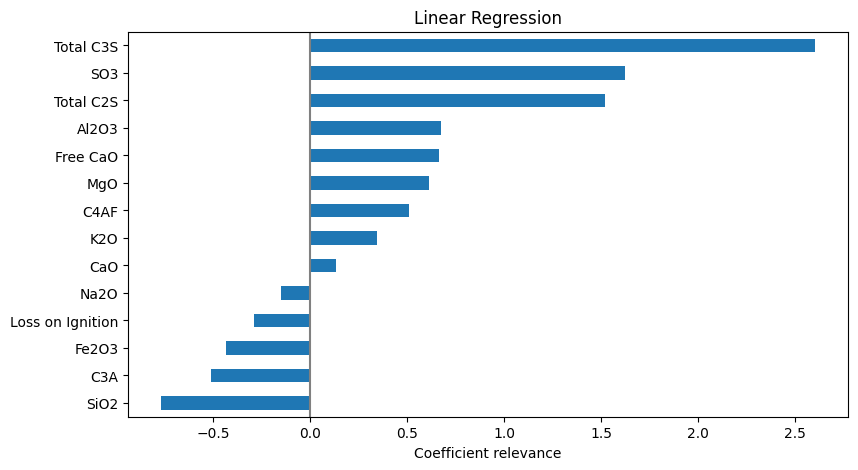

<IPython.core.display.Javascript object>

In [22]:
df_coefs.mean(axis=0).shape

df_coefs.mean(axis=0).sort_values(ascending=True).plot(kind="barh", figsize=(12, 5))
plt.title("Linear Regression")
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient relevance")
plt.subplots_adjust(left=0.3)

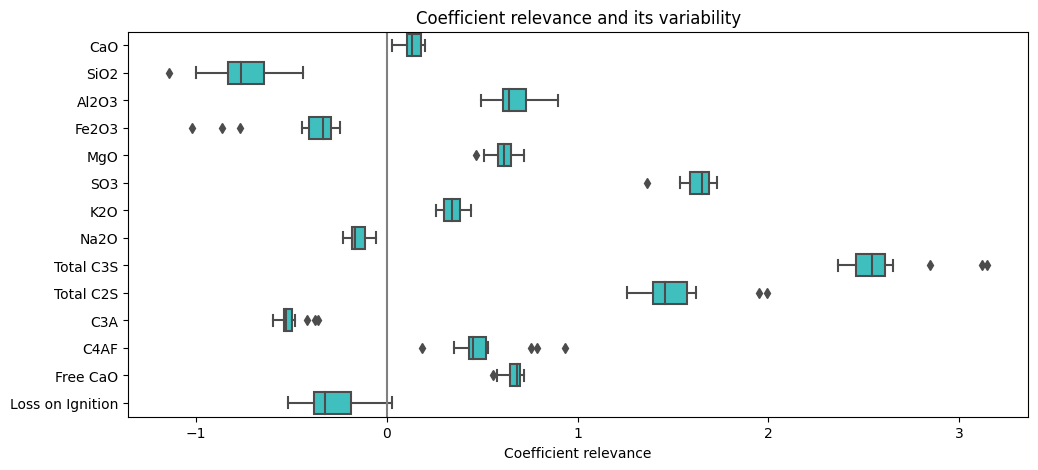

<IPython.core.display.Javascript object>

In [23]:
import warnings

warnings.filterwarnings("ignore")

plt.figure(figsize=(15, 5))
sns.boxplot(data=df_coefs, orient="h", color="cyan", saturation=0.5)
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient relevance")
plt.title("Coefficient relevance and its variability")
plt.subplots_adjust(left=0.3)

In [24]:
df_coefs.describe().T

,count,mean,std,min,25%,50%,75%,max
CaO,15.0,0.134901,0.048352,0.026369,0.106068,0.131899,0.177049,0.202225
SiO2,15.0,-0.767922,0.185296,-1.142409,-0.834425,-0.764081,-0.646599,-0.439855
Al2O3,15.0,0.674399,0.110995,0.492978,0.608577,0.641126,0.727289,0.896862
Fe2O3,15.0,-0.434282,0.244083,-1.021808,-0.408853,-0.333451,-0.295370,-0.246224
MgO,15.0,0.612712,0.067272,0.466615,0.583128,0.615471,0.652126,0.716524
SO3,15.0,1.624634,0.090272,1.364060,1.590552,1.651286,1.690789,1.729492
K2O,15.0,0.344524,0.054103,0.255088,0.298057,0.342153,0.381683,0.438623
Na2O,15.0,-0.149657,0.048976,-0.228421,-0.183120,-0.166941,-0.115511,-0.056848
Total C3S,15.0,2.603420,0.245537,2.365293,2.458498,2.543806,2.612960,3.147853
Total C2S,15.0,1.517808,0.212280,1.260025,1.395046,1.460714,1.574837,1.992580


<IPython.core.display.Javascript object>

# 1. XGBoost

In [19]:
# Modeling
from xgboost import XGBRegressor
from xgboost import plot_importance

<IPython.core.display.Javascript object>

In [20]:
results_to_save = []

results_dict = {
    "Category": "Local Model",
    "Company": "partner_ii",
    "Features": "Chemical + Mineralogical",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "XGBoost",
    "Model Params": None,
    "Scaler": None,
    "Scaler Params": None,
    "Imputer": None,
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

In [21]:
df_copy = df.drop(
    [
        # Properties
        "loi",
        "water_demand",
        "setting_initial",
        "blaine",
        "sieve_32um",
        "sieve_45um",
        "CS1",
        "CS3",
        "CS7",
        # Removing One-Hot encoding variables
        "unified_material_name_Type III",
        "unified_material_name_Type IL",
    ],
    axis=1,
).copy()


y = df_copy.pop("CS28").values
x = df_copy.drop(["Date"], axis=1)
dates = df["Date"].copy()

<IPython.core.display.Javascript object>

In [22]:
PARAMS = {
    "objective": "reg:squarederror",
    "n_estimators": 5,
    "max_depth": 3,
    "random_state": SEED,
    "verbosity": 0,
    "silent": True,
}

<IPython.core.display.Javascript object>

## Repeated KFold

In [23]:
repeats = 3
n_splits = 5
pipeline = Pipeline(
    [
        ("estimator", XGBRegressor(**PARAMS)),
    ]
)
cv = RepeatedKFold(n_splits=n_splits, n_repeats=repeats, random_state=SEED)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    return_estimator=True,
)
print("Repeated Cross Validation:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Repeated KFold"
results_dict_copy["Cross Validation Params"] = '{"N_Splits": 5, "Repeats": 3}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

Repeated Cross Validation:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -2.374 (0.026)
MAE: -1.867 (0.024)
MAPE: -0.044 (0.001)
R2: 0.549 (0.012)


******
[TEST]
******
RMSE: -2.569 (0.111)
MAE: -2.009 (0.092)
MAPE: -0.047 (0.002)
R2: 0.467 (0.042)




/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

<IPython.core.display.Javascript object>

   1. Weight: Reflects the number of times a feature is used to split the data across all trees.
   
   
   2. Gain: Measures the improvement in accuracy brought by a feature to the branches it is on. This is relevant for regression with squared error, as it directly reflects the reduction in the squared error.
   
   3. Cover: Represents the relative quantity of observations concerned by a feature.

https://xgboost.readthedocs.io/en/stable/python/python_api.html

https://forecastegy.com/posts/xgboost-feature-importance-python/

1. ‘weight’: the number of times a feature is used to split the data across all trees.

2.  ‘gain’: the average gain across all splits the feature is used in.

3.  ‘cover’: the average coverage across all splits the feature is used in.

4. ‘total_gain’: the total gain across all splits the feature is used in.

5.  ‘total_cover’: the total coverage across all splits the feature is used in.


In [24]:
df_importances = get_xgboost_importances(scores, importance_type="gain")

<IPython.core.display.Javascript object>

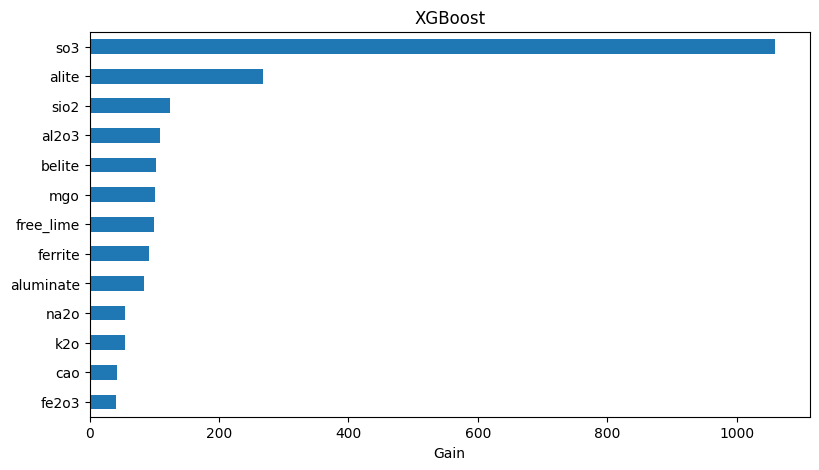

<IPython.core.display.Javascript object>

In [25]:
df_importances.mean(axis=0).sort_values().plot(kind="barh", figsize=(12, 5))
plt.title("XGBoost")
plt.xlabel("Gain")
plt.subplots_adjust(left=0.3)

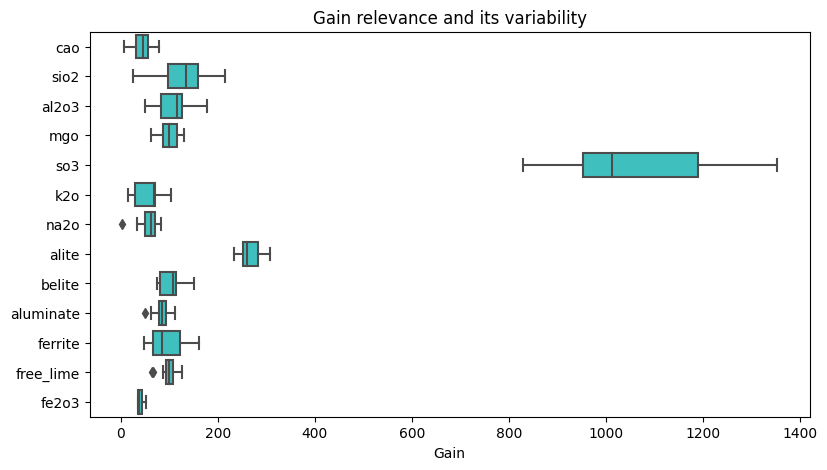

<IPython.core.display.Javascript object>

In [26]:
import warnings

warnings.filterwarnings("ignore")

plt.figure(figsize=(12, 5))
sns.boxplot(data=df_importances, orient="h", color="cyan", saturation=0.5)
plt.xlabel("Gain")
plt.title("Gain relevance and its variability")
plt.subplots_adjust(left=0.3)

In [27]:
df_importances.describe().T

,count,mean,std,min,25%,50%,75%,max
cao,13.0,41.760527,20.680613,5.382820,31.912853,44.632313,55.192654,78.473114
sio2,14.0,123.855837,51.872326,25.206970,97.704161,133.991425,159.838268,214.583618
al2o3,15.0,109.270261,31.805666,50.528069,83.595665,115.578232,125.792801,178.025024
mgo,15.0,100.255354,19.122379,62.287304,87.175255,98.259331,114.760742,130.070389
so3,15.0,1060.154232,152.844892,828.865601,952.854736,1012.949280,1189.488037,1352.971558
k2o,10.0,54.563873,28.841898,14.770481,28.670887,67.198967,69.845642,102.223877
na2o,8.0,55.022560,25.723672,3.067497,49.343249,62.150032,70.761326,83.354561
alite,15.0,267.267059,22.876395,233.825104,251.698219,260.856842,282.902023,307.012299
belite,7.0,102.468312,26.839951,74.090988,80.033203,106.859406,113.157921,149.945541
aluminate,15.0,83.581705,15.813726,49.964806,78.727661,84.933830,93.739967,110.835327


<IPython.core.display.Javascript object>

# Chemical + Mineralogical + Physical Features

In [28]:
results_to_save = []

results_dict = {
    "Category": "Local Model",
    "Company": "partner_ii",
    "Features": "Chemical + Mineralogical + CS3 + CS7",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "Linear Regression",
    "Model Params": None,
    "Scaler": "Standard Scaler",
    "Scaler Params": None,
    "Imputer": "Median",
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

# Linear Regression

## Defining Features

In this set of experiments we keep all features

In [29]:
df_copy = df.drop(
    [
        # Properties
        "loi",
        "water_demand",
        "setting_initial",
        "blaine",
        "sieve_32um",
        "sieve_45um",
        "CS1",
        "unified_material_name_Type III",
        "unified_material_name_Type IL",
    ],
    axis=1,
).copy()

<IPython.core.display.Javascript object>

<h2>1. Dataset: df_copy</h2> <br>In this dataset all features are used.

In [30]:
y = df_copy.pop("CS28").values
x = df_copy.drop(["Date"], axis=1)
dates = df["Date"].copy()

<IPython.core.display.Javascript object>

## 1.1 Repeated KFold Cross validation


In [31]:
repeats = 3
n_splits = 5
pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("transformer", StandardScaler()),
        ("estimator", LinearRegression()),
    ]
)
cv = RepeatedKFold(n_splits=n_splits, n_repeats=repeats, random_state=SEED)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    return_estimator=True,
)
print("Repeated Cross Validation:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Repeated KFold"
results_dict_copy["Cross Validation Params"] = '{"N_Splits": 5, "Repeats": 3}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Repeated Cross Validation:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -1.467 (0.014)
MAE: -1.158 (0.013)
MAPE: -0.027 (0.000)
R2: 0.828 (0.005)


******
[TEST]
******
RMSE: -1.493 (0.057)
MAE: -1.179 (0.050)
MAPE: -0.028 (0.001)
R2: 0.819 (0.022)




<IPython.core.display.Javascript object>

In [32]:
df_coefs, df_bias = get_linreg_df_importances(scores)

<IPython.core.display.Javascript object>

In [33]:
df_coefs.mean().sort_values().to_frame().style.background_gradient(
    axis=None, vmin=1, vmax=5, cmap="Greens"
)

,0
k2o,-0.287604
so3,-0.271908
aluminate,-0.243442
fe2o3,-0.092797
ferrite,-0.053554
cao,-0.031438
na2o,0.015586
sio2,0.047841
mgo,0.091760
free_lime,0.136831


<IPython.core.display.Javascript object>

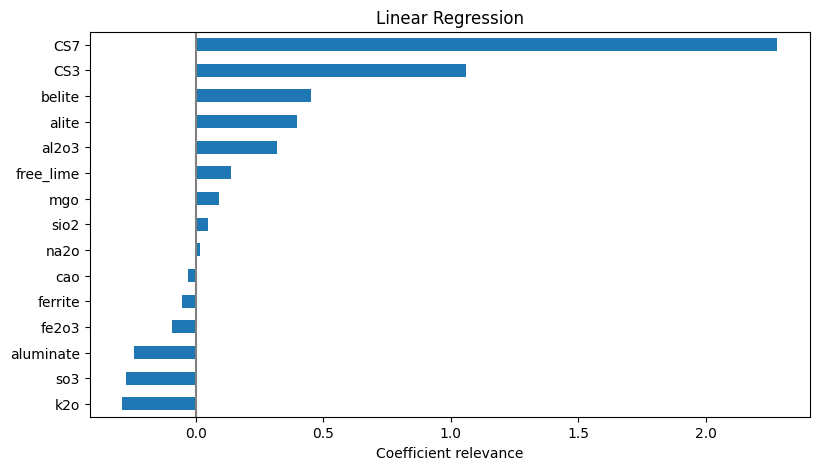

<IPython.core.display.Javascript object>

In [35]:
df_coefs.mean(axis=0).shape

df_coefs.mean(axis=0).sort_values(ascending=True).plot(kind="barh", figsize=(12, 5))
plt.title("Linear Regression")
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient relevance")
plt.subplots_adjust(left=0.3)

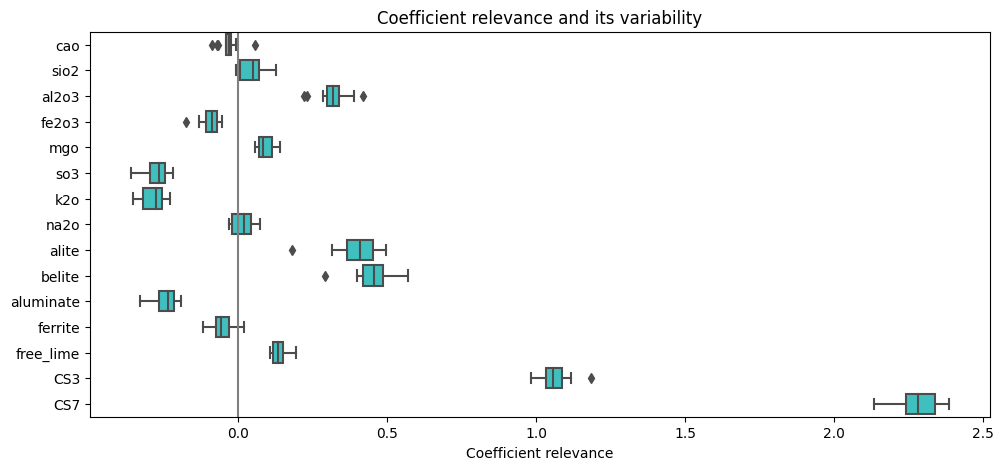

<IPython.core.display.Javascript object>

In [36]:
import warnings

warnings.filterwarnings("ignore")

plt.figure(figsize=(15, 5))
sns.boxplot(data=df_coefs, orient="h", color="cyan", saturation=0.5)
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient relevance")
plt.title("Coefficient relevance and its variability")
plt.subplots_adjust(left=0.3)

In [35]:
df_coefs.describe().T

,count,mean,std,min,25%,50%,75%,max
cao,15.0,-0.031438,0.032454,-0.088502,-0.038672,-0.030157,-0.024917,0.057284
sio2,15.0,0.047841,0.041796,-0.005977,0.005678,0.051687,0.071706,0.126032
al2o3,15.0,0.318518,0.051332,0.221373,0.298609,0.318262,0.340019,0.417649
fe2o3,15.0,-0.092797,0.032693,-0.174107,-0.106874,-0.087862,-0.071376,-0.053556
mgo,15.0,0.091760,0.028773,0.055430,0.069055,0.082209,0.115517,0.139450
so3,15.0,-0.271908,0.038973,-0.360186,-0.295406,-0.265018,-0.243447,-0.216992
k2o,15.0,-0.287604,0.037788,-0.353269,-0.318344,-0.276256,-0.256020,-0.227316
na2o,15.0,0.015586,0.035349,-0.031382,-0.021817,0.019234,0.042018,0.072448
alite,15.0,0.397595,0.082232,0.180821,0.364072,0.409869,0.452740,0.498056
belite,15.0,0.452228,0.063959,0.292666,0.418293,0.454604,0.486080,0.570957


<IPython.core.display.Javascript object>

# Random Forest

## Defining a dataframe structure to save the results

In [37]:
results_to_save = []

results_dict = {
    "Category": "Local Model",
    "Company": "partner_ii",
    "Features": "Chemical + Mineralogical + Physical",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "Random Forest",
    "Model Params": None,
    "Scaler": "Standard Scaler",
    "Scaler Params": None,
    "Imputer": "Median",
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

## Defining Features

In this set of experiments we keep all features

In [38]:
df_copy = df.copy().drop(
    ["unified_material_name_Type III", "unified_material_name_Type IL"], axis=1
)

<IPython.core.display.Javascript object>

In [39]:
y = df_copy.pop("CS28").values
x = df_copy.drop(["Date"], axis=1)
dates = df["Date"].copy()

<IPython.core.display.Javascript object>

In [40]:
PARAMS = {
    "criterion": "squared_error",
    "n_estimators": 5,
    "max_depth": 3,
    "random_state": SEED,
}

<IPython.core.display.Javascript object>

## 1.1 Repeated KFold Cross validation

In [41]:
repeats = 3
n_splits = 5
pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("estimator", RandomForestRegressor(**PARAMS)),
    ]
)
cv = RepeatedKFold(n_splits=n_splits, n_repeats=repeats, random_state=SEED)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    return_estimator=True,
)
print("Repeated Cross Validation:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Repeated KFold"
results_dict_copy["Cross Validation Params"] = '{"N_Splits": 5, "Repeats": 3}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Repeated Cross Validation:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -1.549 (0.018)
MAE: -1.220 (0.016)
MAPE: -0.029 (0.000)
R2: 0.808 (0.006)


******
[TEST]
******
RMSE: -1.660 (0.069)
MAE: -1.312 (0.060)
MAPE: -0.031 (0.002)
R2: 0.776 (0.026)




<IPython.core.display.Javascript object>

In [42]:
df_importances = get_random_forest_df_importances(scores)
df_importances = df_importances.rename(
    {
        "unified_material_name_Type III": "Cem Type A",
        "unified_material_name_Type IL": "Cem Type B",
    },
    axis=1,
)

<IPython.core.display.Javascript object>

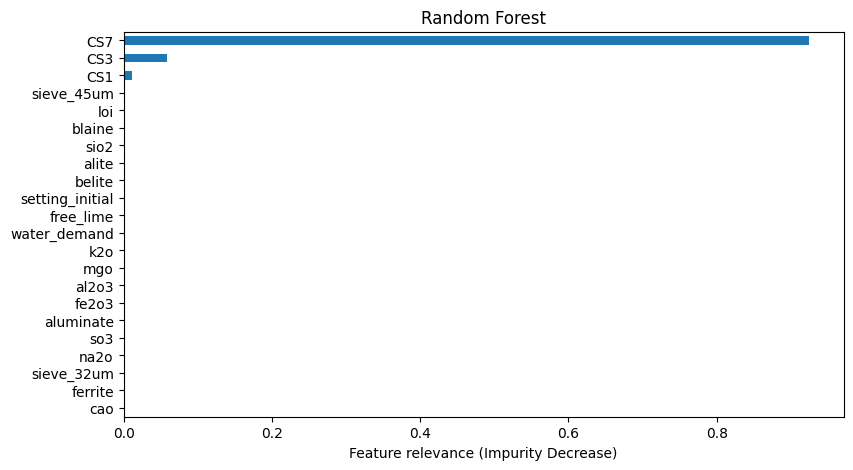

<IPython.core.display.Javascript object>

In [44]:
df_importances.mean(axis=0).sort_values().plot(kind="barh", figsize=(12, 5))
plt.title("Random Forest")
plt.xlabel("Feature relevance (Impurity Decrease)")
plt.subplots_adjust(left=0.3)

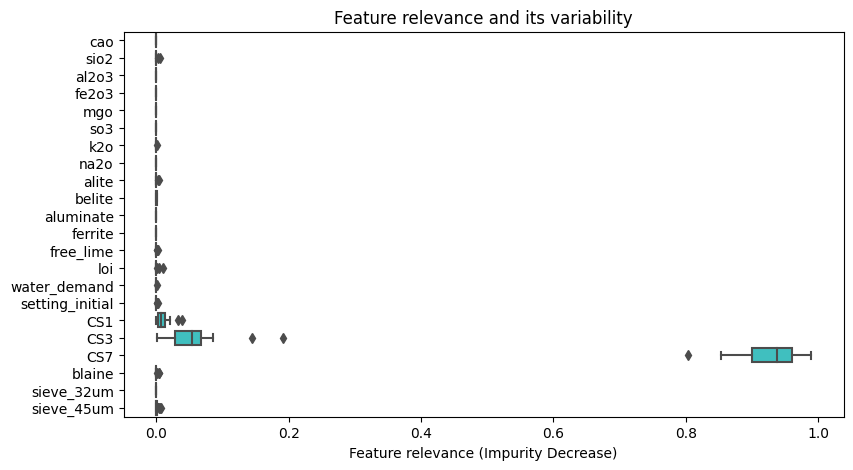

<IPython.core.display.Javascript object>

In [45]:
import warnings

warnings.filterwarnings("ignore")

plt.figure(figsize=(12, 5))
sns.boxplot(data=df_importances, orient="h", color="cyan", saturation=0.5)
plt.xlabel("Feature relevance (Impurity Decrease)")
plt.title("Feature relevance and its variability")
plt.subplots_adjust(left=0.3)

In [62]:
df_importances.describe().T

,count,mean,std,min,25%,50%,75%,max
cao,15.0,0.001117,0.002395,0.000000,0.000000,0.000000,0.001355,0.009357
sio2,15.0,0.012472,0.007092,0.003762,0.007164,0.010430,0.015796,0.026410
al2o3,15.0,0.006640,0.004745,0.000000,0.003855,0.005202,0.009784,0.014482
fe2o3,15.0,0.001706,0.002065,0.000000,0.000000,0.001927,0.002647,0.007240
mgo,15.0,0.017322,0.008072,0.000000,0.014072,0.017804,0.023572,0.028329
so3,15.0,0.010511,0.007066,0.000000,0.004152,0.009860,0.017588,0.020813
k2o,15.0,0.002943,0.002598,0.000000,0.000000,0.003618,0.004308,0.008151
na2o,15.0,0.002962,0.003361,0.000000,0.000000,0.002685,0.005266,0.008529
alite,15.0,0.136058,0.009274,0.124942,0.128896,0.132883,0.141005,0.160228
belite,15.0,0.011480,0.008393,0.000000,0.006433,0.010925,0.014755,0.031703


<IPython.core.display.Javascript object>

# Chemical + Mineralogical + Cement Type

# Linear Regression

## Defining a dataframe structure to save the results

In [45]:
results_to_save = []

results_dict = {
    "Category": "Local Model",
    "Company": "partner_ii",
    "Features": "Chemical + Mineralogical + One-Hot",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "Linear Regression",
    "Model Params": None,
    "Scaler": "Standard Scaler",
    "Scaler Params": None,
    "Imputer": "Median",
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

## Defining Features

In this set of experiments we keep only chemical and mineralogical features yielded by the same testing method/procedure

In [46]:
df_copy = df.drop(
    [
        # Properties
        "loi",
        "water_demand",
        "setting_initial",
        "blaine",
        "sieve_32um",
        "sieve_45um",
        "CS1",
        "CS3",
        "CS7",
    ],
    axis=1,
).copy()

df[["unified_material_name_Type III", "unified_material_name_Type IL"]] = df[
    ["unified_material_name_Type III", "unified_material_name_Type IL"]
].astype(int)

<IPython.core.display.Javascript object>

<h2>1. Dataset: df_no_cs</h2> <br>In this dataset the CS1, CS3  and CS7 variables are not considered. Only Chemical and mineralogical features measured by the same method. For this particular dataset, all chemical features, with the exception of LOI were measured by XRF and XRD methods.

In [47]:
y = df_copy.pop("CS28").values
x = df_copy.drop(["Date"], axis=1)
dates = df["Date"].copy()

<IPython.core.display.Javascript object>

## 1.1 Repeated KFold Cross validation

In [48]:
repeats = 3
n_splits = 5
pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("transformer", StandardScaler()),
        ("estimator", LinearRegression()),
    ]
)
cv = RepeatedKFold(n_splits=n_splits, n_repeats=repeats, random_state=SEED)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    return_estimator=True,
)
print("Repeated Cross Validation:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Repeated KFold"
results_dict_copy["Cross Validation Params"] = '{"N_Splits": 5, "Repeats": 3}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Repeated Cross Validation:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -2.145 (0.022)
MAE: -1.715 (0.013)
MAPE: -0.040 (0.000)
R2: 0.632 (0.008)


******
[TEST]
******
RMSE: -2.203 (0.098)
MAE: -1.749 (0.054)
MAPE: -0.041 (0.001)
R2: 0.607 (0.036)




<IPython.core.display.Javascript object>

In [49]:
df_coefs, df_bias = get_linreg_df_importances(scores)
df_coefs = df_coefs.rename(
    {
        "unified_material_name_Type III": "Cem Type A",
        "unified_material_name_Type IL": "Cem Type B",
    },
    axis=1,
)

<IPython.core.display.Javascript object>

In [50]:
df_coefs.mean().sort_values().to_frame().style.background_gradient(
    axis=None, vmin=1, vmax=5, cmap="Greens"
)

,0
aluminate,-0.461706
fe2o3,-0.325700
cao,-0.187213
k2o,-0.152820
so3,-0.122008
na2o,-0.060069
belite,-0.046602
sio2,0.185897
ferrite,0.235919
Cem Type B,0.339868


<IPython.core.display.Javascript object>

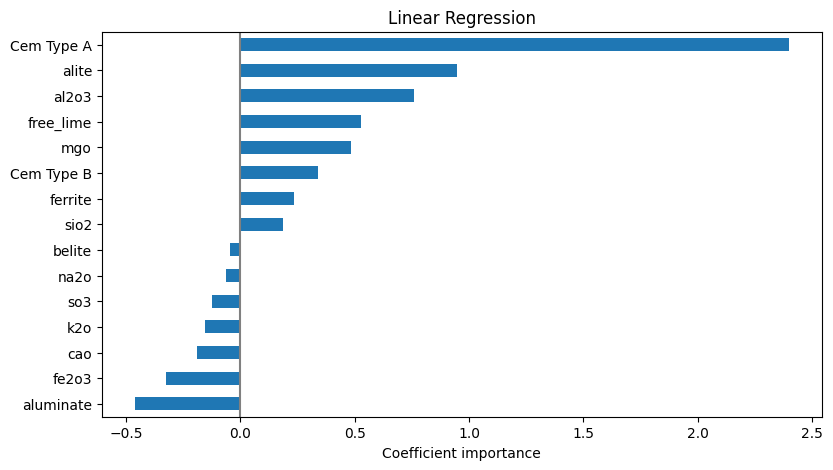

<IPython.core.display.Javascript object>

In [51]:
df_coefs.mean(axis=0).shape

df_coefs.mean(axis=0).sort_values(ascending=True).plot(kind="barh", figsize=(12, 5))
plt.title("Linear Regression")
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient importance")
plt.subplots_adjust(left=0.3)

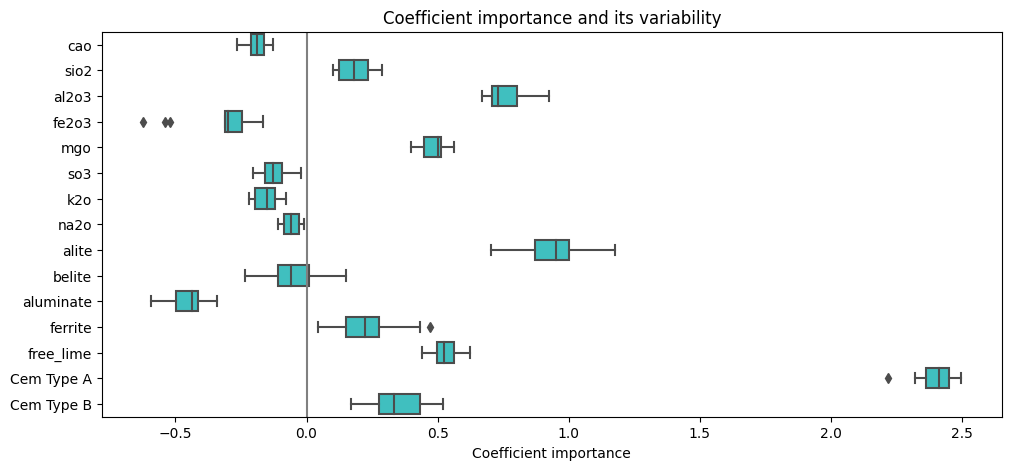

<IPython.core.display.Javascript object>

In [52]:
import warnings

warnings.filterwarnings("ignore")

plt.figure(figsize=(15, 5))
sns.boxplot(data=df_coefs, orient="h", color="cyan", saturation=0.5)
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient importance")
plt.title("Coefficient importance and its variability")
plt.subplots_adjust(left=0.3)

In [53]:
df_coefs.describe().T

,count,mean,std,min,25%,50%,75%,max
cao,15.0,-0.187213,0.035116,-0.264783,-0.211034,-0.187278,-0.162574,-0.127810
sio2,15.0,0.185897,0.063849,0.101834,0.124427,0.181009,0.233352,0.288960
al2o3,15.0,0.759723,0.074131,0.669102,0.706736,0.729959,0.801596,0.923165
fe2o3,15.0,-0.325700,0.129836,-0.624776,-0.312058,-0.300302,-0.247383,-0.167632
mgo,15.0,0.486026,0.046503,0.399951,0.449815,0.503367,0.514118,0.563282
so3,15.0,-0.122008,0.050024,-0.203883,-0.158429,-0.127369,-0.092940,-0.021100
k2o,15.0,-0.152820,0.046267,-0.221229,-0.197747,-0.150802,-0.120259,-0.076459
na2o,15.0,-0.060069,0.033718,-0.109481,-0.084941,-0.058599,-0.030262,-0.008460
alite,15.0,0.948952,0.117723,0.705007,0.872281,0.949999,1.002681,1.176779
belite,15.0,-0.046602,0.104140,-0.234994,-0.109948,-0.059676,0.007498,0.152004


<IPython.core.display.Javascript object>

# Random Forest

## Defining a dataframe structure to save the results

In [54]:
results_to_save = []

results_dict = {
    "Category": "Local Model",
    "Company": "partner_ii",
    "Features": "Chemical + Mineralogical + One-Hot",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "Random Forest",
    "Model Params": None,
    "Scaler": "Standard Scaler",
    "Scaler Params": None,
    "Imputer": "Median",
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

## Defining Features

In this set of experiments we keep all features

In [55]:
df[["unified_material_name_Type III", "unified_material_name_Type IL"]] = df[
    ["unified_material_name_Type III", "unified_material_name_Type IL"]
].astype(int)

df_copy = df.drop(
    [
        # Properties
        "loi",
        "water_demand",
        "setting_initial",
        "blaine",
        "sieve_32um",
        "sieve_45um",
        "CS1",
        "CS3",
        "CS7",
    ],
    axis=1,
).copy()

<IPython.core.display.Javascript object>

<h2>1. Dataset: df_copy</h2> <br>In this dataset all features are used.

In [56]:
y = df_copy.pop("CS28").values
x = df_copy.drop(["Date"], axis=1)
dates = df["Date"].copy()

<IPython.core.display.Javascript object>

In [57]:
PARAMS = {
    "criterion": "squared_error",
    "n_estimators": 5,
    "max_depth": 3,
    "random_state": SEED,
}

<IPython.core.display.Javascript object>

## 1.1 Repeated KFold Cross validation

In [58]:
repeats = 3
n_splits = 5
pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("estimator", RandomForestRegressor(**PARAMS)),
    ]
)
cv = RepeatedKFold(n_splits=n_splits, n_repeats=repeats, random_state=SEED)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    return_estimator=True,
)
print("Repeated Cross Validation:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Repeated KFold"
results_dict_copy["Cross Validation Params"] = '{"N_Splits": 5, "Repeats": 3}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Repeated Cross Validation:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -2.151 (0.022)
MAE: -1.716 (0.019)
MAPE: -0.040 (0.000)
R2: 0.630 (0.009)


******
[TEST]
******
RMSE: -2.286 (0.090)
MAE: -1.820 (0.058)
MAPE: -0.043 (0.002)
R2: 0.577 (0.040)




<IPython.core.display.Javascript object>

In [59]:
df_importances = get_random_forest_df_importances(scores)
df_importances = df_importances.rename(
    {
        "unified_material_name_Type III": "Cem Type A",
        "unified_material_name_Type IL": "Cem Type B",
    },
    axis=1,
)

<IPython.core.display.Javascript object>

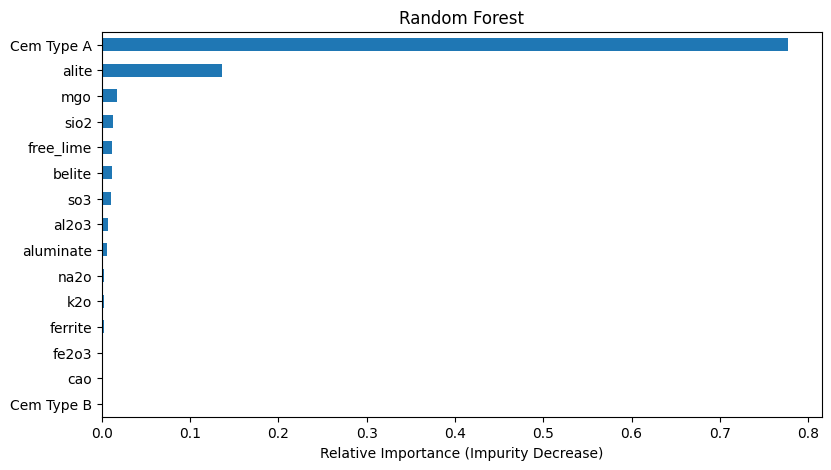

<IPython.core.display.Javascript object>

In [60]:
df_importances.mean(axis=0).sort_values().plot(kind="barh", figsize=(12, 5))
plt.title("Random Forest")
plt.xlabel("Relative Importance (Impurity Decrease)")
plt.subplots_adjust(left=0.3)

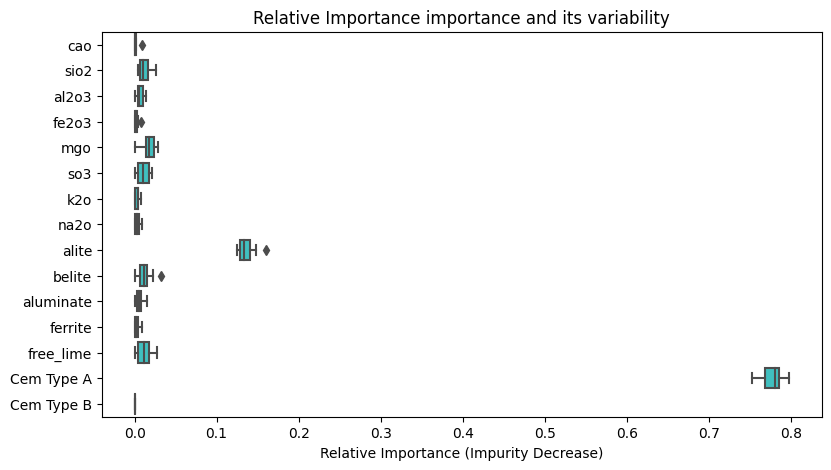

<IPython.core.display.Javascript object>

In [61]:
import warnings

warnings.filterwarnings("ignore")

plt.figure(figsize=(12, 5))
sns.boxplot(data=df_importances, orient="h", color="cyan", saturation=0.5)
plt.xlabel("Relative Importance (Impurity Decrease)")
plt.title("Relative Importance importance and its variability")
plt.subplots_adjust(left=0.3)

In [62]:
df_importances.describe().T

,count,mean,std,min,25%,50%,75%,max
cao,15.0,0.001117,0.002395,0.000000,0.000000,0.000000,0.001355,0.009357
sio2,15.0,0.012472,0.007092,0.003762,0.007164,0.010430,0.015796,0.026410
al2o3,15.0,0.006640,0.004745,0.000000,0.003855,0.005202,0.009784,0.014482
fe2o3,15.0,0.001706,0.002065,0.000000,0.000000,0.001927,0.002647,0.007240
mgo,15.0,0.017322,0.008072,0.000000,0.014072,0.017804,0.023572,0.028329
so3,15.0,0.010511,0.007066,0.000000,0.004152,0.009860,0.017588,0.020813
k2o,15.0,0.002943,0.002598,0.000000,0.000000,0.003618,0.004308,0.008151
na2o,15.0,0.002962,0.003361,0.000000,0.000000,0.002685,0.005266,0.008529
alite,15.0,0.136058,0.009274,0.124942,0.128896,0.132883,0.141005,0.160228
belite,15.0,0.011480,0.008393,0.000000,0.006433,0.010925,0.014755,0.031703


<IPython.core.display.Javascript object>

# Chemical + Mineralogical + Physical + Cement Type

# Linear Regression

## Defining a dataframe structure to save the results

In [63]:
results_to_save = []

results_dict = {
    "Category": "Local Model",
    "Company": "partner_ii",
    "Features": "Chemical + Mineralogical + CS1 + CS3 + CS7 + One-Hot",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "Linear Regression",
    "Model Params": None,
    "Scaler": "Standard Scaler",
    "Scaler Params": None,
    "Imputer": "Median",
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

## Defining the Features

In [64]:
df_copy = df.drop(
    [
        # Properties
        "loi",
        "water_demand",
        "setting_initial",
        "blaine",
        "sieve_32um",
        "sieve_45um",
    ],
    axis=1,
).copy()

df[["unified_material_name_Type III", "unified_material_name_Type IL"]] = df[
    ["unified_material_name_Type III", "unified_material_name_Type IL"]
].astype(int)

<IPython.core.display.Javascript object>

In [65]:
y = df_copy.pop("CS28").values
x = df_copy.drop(["Date"], axis=1)
dates = df["Date"].copy()

<IPython.core.display.Javascript object>

## 1.1 Repeated KFold Cross validation

In [66]:
repeats = 3
n_splits = 5
pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("transformer", StandardScaler()),
        ("estimator", LinearRegression()),
    ]
)
cv = RepeatedKFold(n_splits=n_splits, n_repeats=repeats, random_state=SEED)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    return_estimator=True,
)
print("Repeated Cross Validation:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Repeated KFold"
results_dict_copy["Cross Validation Params"] = '{"N_Splits": 5, "Repeats": 3}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Repeated Cross Validation:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -1.443 (0.015)
MAE: -1.133 (0.013)
MAPE: -0.027 (0.000)
R2: 0.833 (0.005)


******
[TEST]
******
RMSE: -1.477 (0.064)
MAE: -1.159 (0.049)
MAPE: -0.027 (0.001)
R2: 0.823 (0.022)




<IPython.core.display.Javascript object>

In [67]:
df_coefs, df_bias = get_linreg_df_importances(scores)
df_coefs = df_coefs.rename(
    {
        "unified_material_name_Type III": "Cem Type A",
        "unified_material_name_Type IL": "Cem Type B",
    },
    axis=1,
)

<IPython.core.display.Javascript object>

In [68]:
df_coefs.mean().sort_values().to_frame().style.background_gradient(
    axis=None, vmin=1, vmax=5, cmap="Greens"
)

,0
Cem Type A,-1.074175
aluminate,-0.250583
Cem Type B,-0.237379
k2o,-0.193135
sio2,-0.145134
fe2o3,-0.107114
so3,-0.103022
ferrite,-0.079632
na2o,-0.004372
cao,0.008960


<IPython.core.display.Javascript object>

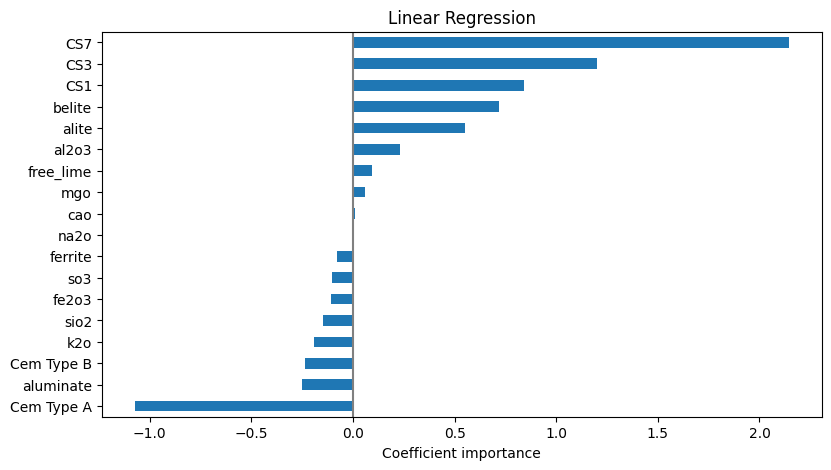

<IPython.core.display.Javascript object>

In [69]:
df_coefs.mean(axis=0).shape

df_coefs.mean(axis=0).sort_values(ascending=True).plot(kind="barh", figsize=(12, 5))
plt.title("Linear Regression")
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient importance")
plt.subplots_adjust(left=0.3)

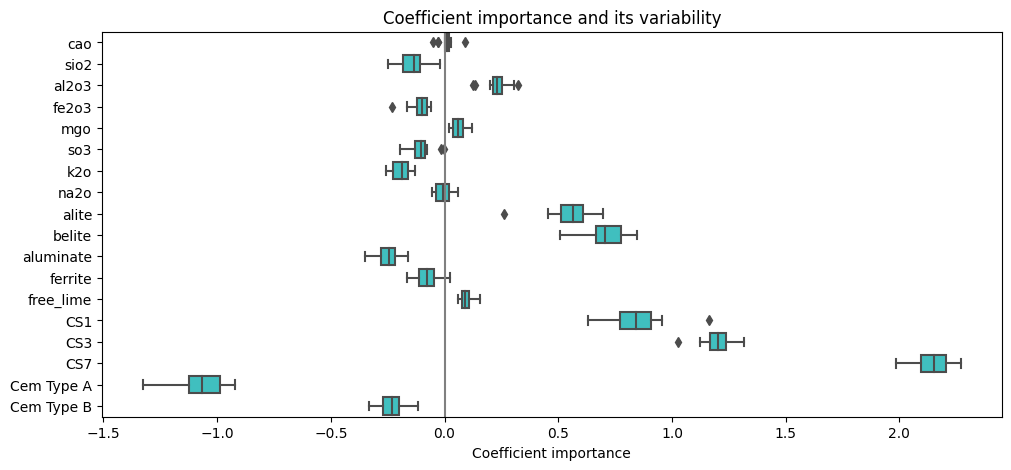

<IPython.core.display.Javascript object>

In [70]:
import warnings

warnings.filterwarnings("ignore")

plt.figure(figsize=(15, 5))
sns.boxplot(data=df_coefs, orient="h", color="cyan", saturation=0.5)
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient importance")
plt.title("Coefficient importance and its variability")
plt.subplots_adjust(left=0.3)

In [71]:
df_coefs.describe().T

,count,mean,std,min,25%,50%,75%,max
cao,15.0,0.008960,0.031314,-0.049325,0.002502,0.012335,0.020708,0.089312
sio2,15.0,-0.145134,0.062014,-0.247236,-0.181020,-0.134710,-0.109665,-0.018395
al2o3,15.0,0.231431,0.052987,0.126653,0.212467,0.232484,0.252693,0.321900
fe2o3,15.0,-0.107114,0.045799,-0.231319,-0.119408,-0.098194,-0.078773,-0.058514
mgo,15.0,0.061222,0.030681,0.021435,0.036262,0.057469,0.083185,0.120033
so3,15.0,-0.103022,0.049395,-0.194333,-0.131565,-0.103562,-0.085124,-0.004326
k2o,15.0,-0.193135,0.040380,-0.256034,-0.225872,-0.189154,-0.162360,-0.129634
na2o,15.0,-0.004372,0.037019,-0.055211,-0.037804,-0.007139,0.020987,0.059410
alite,15.0,0.551825,0.107604,0.260259,0.511146,0.562962,0.610195,0.698550
belite,15.0,0.717967,0.088909,0.506151,0.665891,0.705737,0.774567,0.846978


<IPython.core.display.Javascript object>

# Random Forest

## Defining a dataframe structure to save the results

In [72]:
results_to_save = []

results_dict = {
    "Category": "Local Model",
    "Company": "partner_ii",
    "Features": "Chemical + Mineralogical + Physical + One-Hot",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "Random Forest",
    "Model Params": None,
    "Scaler": "Standard Scaler",
    "Scaler Params": None,
    "Imputer": "Median",
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

## Defining Features

In this set of experiments we keep all features

In [73]:
df_copy = df.copy()

df[["unified_material_name_Type III", "unified_material_name_Type IL"]] = df[
    ["unified_material_name_Type III", "unified_material_name_Type IL"]
].astype(int)

<IPython.core.display.Javascript object>

In [74]:
y = df_copy.pop("CS28").values
x = df_copy.drop(["Date"], axis=1)
dates = df["Date"].copy()

<IPython.core.display.Javascript object>

In [75]:
PARAMS = {
    "criterion": "squared_error",
    "n_estimators": 5,
    "max_depth": 3,
    "random_state": SEED,
}

<IPython.core.display.Javascript object>

## 1.1. Repeated KFold Cross validation

In [76]:
repeats = 3
n_splits = 5
pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("estimator", RandomForestRegressor(**PARAMS)),
    ]
)
cv = RepeatedKFold(n_splits=n_splits, n_repeats=repeats, random_state=SEED)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    return_estimator=True,
)
print("Repeated Cross Validation:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Repeated KFold"
results_dict_copy["Cross Validation Params"] = '{"N_Splits": 5, "Repeats": 3}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Repeated Cross Validation:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -1.549 (0.018)
MAE: -1.220 (0.016)
MAPE: -0.029 (0.000)
R2: 0.808 (0.006)


******
[TEST]
******
RMSE: -1.660 (0.069)
MAE: -1.312 (0.060)
MAPE: -0.031 (0.002)
R2: 0.776 (0.026)




<IPython.core.display.Javascript object>

In [77]:
df_importances = get_random_forest_df_importances(scores)
df_importances = df_importances.rename(
    {
        "unified_material_name_Type III": "Cem Type A",
        "unified_material_name_Type IL": "Cem Type B",
    },
    axis=1,
)

<IPython.core.display.Javascript object>

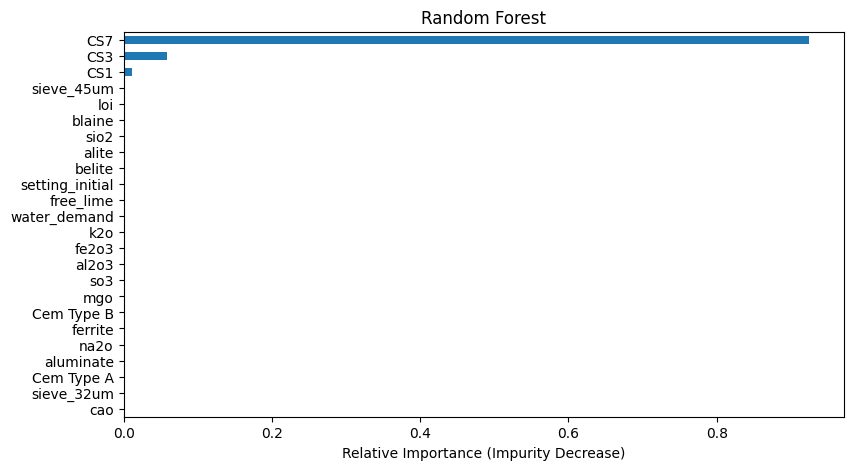

<IPython.core.display.Javascript object>

In [78]:
df_importances.mean(axis=0).sort_values().plot(kind="barh", figsize=(12, 5))
plt.title("Random Forest")
plt.xlabel("Relative Importance (Impurity Decrease)")
plt.subplots_adjust(left=0.3)

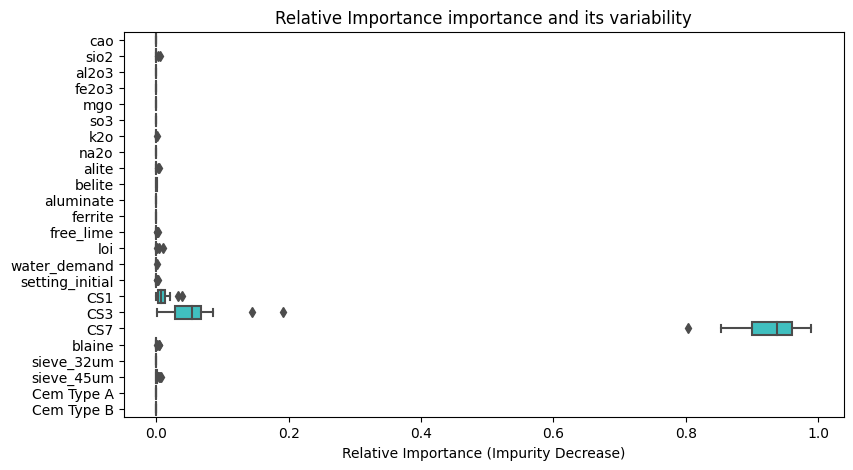

<IPython.core.display.Javascript object>

In [79]:
import warnings

warnings.filterwarnings("ignore")

plt.figure(figsize=(12, 5))
sns.boxplot(data=df_importances, orient="h", color="cyan", saturation=0.5)
plt.xlabel("Relative Importance (Impurity Decrease)")
plt.title("Relative Importance importance and its variability")
plt.subplots_adjust(left=0.3)

In [80]:
df_importances.describe().T

,count,mean,std,min,25%,50%,75%,max
cao,15.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sio2,15.0,0.000538,0.001456,0.000000,0.000000,0.000000,0.000000,0.004896
al2o3,15.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
fe2o3,15.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
mgo,15.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
so3,15.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
k2o,15.0,0.000080,0.000309,0.000000,0.000000,0.000000,0.000000,0.001195
na2o,15.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
alite,15.0,0.000416,0.001140,0.000000,0.000000,0.000000,0.000000,0.003926
belite,15.0,0.000415,0.000713,0.000000,0.000000,0.000000,0.000759,0.001586


<IPython.core.display.Javascript object>